In [1]:
import matplotlib.pyplot as plt
%pylab inline

import seaborn as sns
sns.set()

import numpy as np

import multiprocessing as mp

from tqdm import tqdm

import os

from functools import partial

%load_ext autoreload

Populating the interactive namespace from numpy and matplotlib


# Estimation of constant via Monte-Carlo

In [ ]:
δ = 0.1
q_alpha = (100*δ)/2

linspace_size = 50
n_samples = np.linspace(100, 1e4, linspace_size, dtype=int)
n_replications = 1000

ϵ = 1

δ_lil = np.log(1+ϵ)**(1+ϵ)/(4*(1 + 1/ϵ))*δ

In [3]:
def plot_percentiles(n_samples, theta_hist, q_alpha):
    plt.plot(n_samples, np.percentile(theta_hist, 100-q_alpha, axis=1), label='(1 - δ)-percentile')
    plt.plot(n_samples, np.percentile(theta_hist, q_alpha, axis=1), label='δ-percentile')
    plt.xlabel('Number of samples')
    plt.legend()

## Squared loss and Gaussian observations

Assume $Y_1, \dots, Y_n$ are i.i.d. standard Gaussian random variables and the loss $\phi$ is given by $\phi(x, y) = (x-y)^2, \forall x,y$.

We have $\hat{\theta}_n = \frac{1}{n}\sum_{i=1}^n Y_i$ and $\theta^* = 0$. 


- Assumption 2.1 holds since $Y$ has a finite expectation

Using the fact that $\phi(y, \theta) - \phi(y, 0)= \theta^2 - 2 \theta y$ we have

- Assumption 2.2 holds with $r=+\infty, \alpha=2$
- Assumption 2.3 holds with $\sigma=2$.

Thus Theorem 2 from the paper (with $\varepsilon=1$) tells us that, for any $\delta \in (0, 1/17)$, with probability at least $1-\delta$,
\begin{align}
\lvert \hat{\theta}_n - \theta^* \rvert \le 4\sqrt{2} \sqrt{\frac{2\ln \ln n + \ln(1/\delta)}{n}}
\end{align}

We want to study the empirical behavior of $\hat{\theta}_n$ to see if our bound is tight.

100%|██████████| 50/50 [00:19<00:00,  1.36it/s]


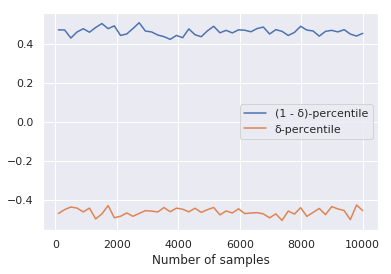

In [7]:
theta_hist = np.zeros((linspace_size, n_replications))

p = mp.Pool(mp.cpu_count())

for idx, n in enumerate(tqdm(n_samples)):
    
    # draw random variables
    Y = np.random.normal(0, 1, n*n_replications)    
    Y_sliced = [Y[k*n:(k+1)*n] for k in range(n_replications)]
    
    theta_hat = np.array(list(p.map(np.mean, Y_sliced)))
    
    theta_hist[idx, :] = np.sqrt(n/(2*np.log(np.log(n)) + np.log(1/δ_lil)))*theta_hat
    
p.close()

plot_percentiles(n_samples, theta_hist, q_alpha)

The plot above shows the empirical percentiles of the distribution of $\sqrt{\frac{n}{2\ln \ln n + \ln (17/\delta)}} \hat{\theta}_n$ as $n$ grows. It seems to be roughly constant and is comprised between 1 and 2 in absolute value.

## Absolute loss and Gaussian observations

Assume $Y_1, \dots, Y_n$ are i.i.d. standard Gaussian random variables and the loss $\phi$ is given by $\phi(x, y) = \lvert x-y \rvert, \forall x,y$.

- Assumption 2.1 is verified since $Y$ has an expectation

We have $\Phi''(\theta) = \sqrt{\frac{2}{\pi}}\exp^{-\theta^2/2}$

- Assumption 2.2 holds for $r=1$ and $\alpha=0.48$ for example

The triangular inequality yields $\lvert \phi(Y, \theta) - \phi(Y, 0) \rvert= \lvert \lvert Y - \theta \rvert - \lvert Y \rvert \rvert  \leq \theta$ thus

- Assumption 2.3 holds for $\sigma=1$.

Thus Theorem 2 from the paper (with $\varepsilon=1$) tells us that, for any $\delta \in (0, 1/17)$, with probability at least $1-\delta$,
\begin{align}
\lvert \hat{\theta}_n - \theta^* \rvert \le 10\sqrt{2} \sqrt{\frac{2\ln \ln n + \ln(17/\delta)}{n}}
\end{align}


100%|██████████| 50/50 [00:17<00:00,  1.66it/s]


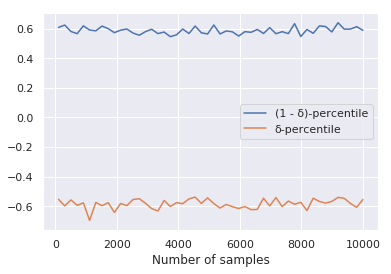

In [10]:
theta_hist = np.zeros((linspace_size, n_replications))
for idx, n in enumerate(tqdm(n_samples)):
    theta_hat = np.array([np.median(np.random.normal(0, 1, n)) for k in range(n_replications)])
    theta_hist[idx, :] = np.sqrt(n/(2*np.log(np.log(n)) + np.log(1/δ_lil)))*theta_hat
plot_percentiles(n_samples, theta_hist, q_alpha)

## Absolute loss and Cauchy observations

100%|██████████| 50/50 [00:28<00:00,  1.03s/it]


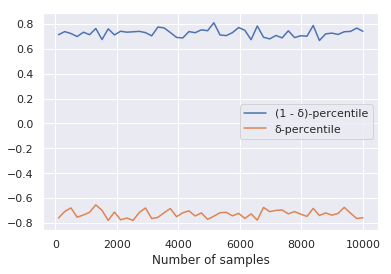

In [11]:
theta_hist = np.zeros((linspace_size, n_replications))
for idx, n in enumerate(tqdm(n_samples)):
    theta_hat = np.array([np.median(np.random.standard_cauchy(n)) for k in range(n_replications)])
    theta_hist[idx, :] = np.sqrt(n/(2*np.log(np.log(n)) + np.log(1/δ_lil)))*theta_hat

plot_percentiles(n_samples, theta_hist, q_alpha)

# Absolute loss and Huber contaminated model

In [ ]:
theta_hist = np.zeros((linspace_size, n_replications))
for idx, n in enumerate(tqdm(n_samples)):
    theta_hat = np.array([np.median(np.random.normal(0, 0.5, n) + (2*np.random.binomial(1, 0.5, n)-1)*np.random.binomial(1, 0.01, n)*1e2) for k in range(n_replications)])
    theta_hist[idx, :] = np.sqrt(n/(2*np.log(np.log(n)) + np.log(1/δ_lil)))*theta_hat
plot_percentiles(n_samples, theta_hist, q_alpha)

## Conclusions
- our theoretical constants are bigger than the empirical constants we estimated on the three examples.
- the convergence rate seems to be tight (the empirical quantiles multiplied by the rate are roughly constant across the number of samples).
- we don't observe a warm-up time $n_0$ in practice

# Robust lil UCB vs vanilla lil UCB

Express the number of pulls as a function of the number of the number of arms.

## Contamination model

In [2]:
%autoreload
from ucb_classes import lilUCB, robust_lilUCB
from mab_class import MAB

In [3]:
def robust_lilUCB_exp(mab, K):    
    robust_lilUCB_proc = robust_lilUCB(δ=0.1, ϵ=1., β=1, K=K)
    
    T = robust_lilUCB_proc.run(mab)
    
    return np.sum(T), np.argmax(T)

In [4]:
def lilUCB_exp(mab, K):    
    lilUCB_proc = lilUCB(δ=0.1, ϵ=0.01, β=1, K=K)
    
    T = lilUCB_proc.run(mab)
    
    return np.sum(T), np.argmax(T)

In [5]:
#%load_ext line_profiler

In [12]:
K = 1000

mab = MAB(K, 'sparse', 'gaussian')

lilUCB_proc = lilUCB(δ=0.1, ϵ=0.01, β=1, K=K)

# lilUCB 
#%lprun -f lilUCB_proc.run lilUCB_proc.run(mab)

In [13]:
lilUCB_proc.δ

5.337604312642313e-06

In [14]:
K = 100

mab = MAB(K, 'sparse', 'gaussian')

robust_lilUCB_proc = robust_lilUCB(δ=0.1, ϵ=1., β=1, K=K)

# lilUCB 
#%lprun -f robust_lilUCB_proc.run robust_lilUCB_proc.run(mab)

robust_lilUCB_proc.δ

0.006005662673977518

## Sparse scenario

In [6]:
nb_of_arms = np.logspace(1, 3, 3, dtype=int)

n_repeat = 100

BAI_lilUCB = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)
BAI_lilUCB_huber = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)
BAI_robustlilUCB_huber = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)
BAI_robustlilUCB = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)

nb_of_pulls_lilUCB = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)
nb_of_pulls_lilUCB_huber = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)
nb_of_pulls_robustlilUCB_huber = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)
nb_of_pulls_robustlilUCB = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)

if 'BAI_lilUCB.npy' not in os.listdir('experiments_results'):

    p = mp.Pool(mp.cpu_count())

    for i, K in enumerate(tqdm(nb_of_arms)): 

        mab = MAB(K, 'sparse', 'gaussian')

        # lilUCB 
        f = partial(lilUCB_exp, mab)
        result = np.array(p.map_async(f, [K]*n_repeat).get())
        nb_of_pulls_lilUCB[i, :] = result[:,0]
        BAI_lilUCB[i, :] = result[:, 1]

        # robust lil UCB
        f = partial(robust_lilUCB_exp, mab)
        result = np.array(p.map_async(f, [K]*n_repeat).get())
        nb_of_pulls_robustlilUCB[i, :] = result[:,0]
        BAI_robustlilUCB[i, :] = result[:, 1]

        mab = MAB(K, 'sparse', 'huber')

        # lilUCB contaminated 
        f = partial(lilUCB_exp, mab)
        result = np.array(p.map_async(f, [K]*n_repeat).get())
        nb_of_pulls_lilUCB_huber[i, :] = result[:,0]
        BAI_lilUCB_huber[i, :] = result[:, 1]

        # robust lilUCB contaminated 
        f = partial(robust_lilUCB_exp, mab)
        result = np.array(p.map_async(f, [K]*n_repeat).get())
        nb_of_pulls_robustlilUCB_huber[i, :] = result[:,0]
        BAI_robustlilUCB_huber[i, :] = result[:, 1]

    np.save('experiments_results/BAI_lilUCB.npy', BAI_lilUCB)    
    np.save('experiments_results/BAI_lilUCB_huber.npy', BAI_lilUCB_huber) 
    np.save('experiments_results/BAI_robustlilUCB_huber.npy', BAI_robustlilUCB_huber) 
    np.save('experiments_results/BAI_robustlilUCB.npy', BAI_robustlilUCB_huber) 

    np.save('experiments_results/nb_of_pulls_lilUCB.npy', nb_of_pulls_lilUCB)
    np.save('experiments_results/nb_of_pulls_lilUCB_huber.npy', nb_of_pulls_lilUCB_huber)
    np.save('experiments_results/nb_of_pulls_robustlilUCB_huber.npy', nb_of_pulls_robustlilUCB_huber)
    np.save('experiments_results/nb_of_pulls_robustlilUCB.npy', nb_of_pulls_robustlilUCB)

    p.close()

else:
    BAI_lilUCB = np.load('experiments_results/BAI_lilUCB.npy')  
    BAI_lilUCB_huber = np.load('experiments_results/BAI_lilUCB_huber.npy')  
    BAI_robustlilUCB_huber = np.load('experiments_results/BAI_robustlilUCB_huber.npy')  
    BAI_robustlilUCB = np.load('experiments_results/BAI_robustlilUCB.npy')  

    nb_of_pulls_lilUCB = np.load('experiments_results/nb_of_pulls_lilUCB.npy')  
    nb_of_pulls_lilUCB_huber = np.load('experiments_results/nb_of_pulls_lilUCB_huber.npy')
    nb_of_pulls_robustlilUCB_huber = np.load('experiments_results/nb_of_pulls_robustlilUCB_huber.npy')
    nb_of_pulls_robustlilUCB = np.load('experiments_results/nb_of_pulls_robustlilUCB.npy')

100%|██████████| 3/3 [23:43<00:00, 403.15s/it]


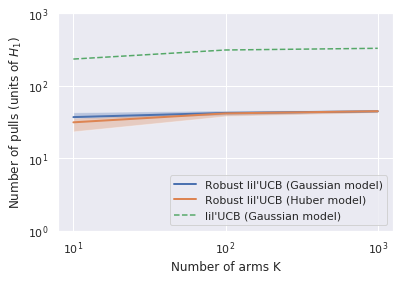

In [18]:
## sns.set()

# grid for both axis
plt.rcParams["axes.grid.axis"] ='both'

H_1 = [4*K for K in nb_of_arms]

# robust lilUCB, Gaussian model
plt.loglog(nb_of_arms, np.mean(nb_of_pulls_robustlilUCB, axis=1)/H_1, linewidth=2)
plt.fill_between(nb_of_arms, np.percentile(nb_of_pulls_robustlilUCB, q=97.5, axis=1)/H_1, 
                 np.percentile(nb_of_pulls_robustlilUCB, axis=1, q=2.5)/H_1, alpha=.3)

# robust lilUCB, Huber model
plt.semilogx(nb_of_arms, np.mean(nb_of_pulls_robustlilUCB_huber, axis=1)/H_1, linewidth=2)
plt.fill_between(nb_of_arms, np.percentile(nb_of_pulls_robustlilUCB_huber, q=97.5, axis=1)/H_1, 
                 np.percentile(nb_of_pulls_robustlilUCB_huber, q=2.5, axis=1)/H_1, alpha=.3)

plt.semilogx(nb_of_arms, np.mean(nb_of_pulls_lilUCB, axis=1)/H_1, linewidth=1.5, linestyle='--')

plt.xlabel('Number of arms K')
plt.ylim(1, 1000)
plt.ylabel('Number of pulls (units of $H_1$)')
plt.legend(["Robust lil'UCB (Gaussian model)", "Robust lil'UCB (Huber model)", "lil'UCB (Gaussian model)"],
           loc='lower right')
savefig('experiments_results/number_of_pulls_sparse.pdf', bbox_inches='tight', dpi=500)

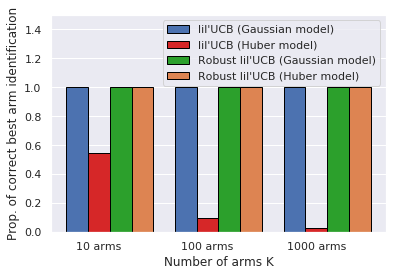

In [19]:
# only display horizontal grid
plt.rcParams["axes.grid.axis"] ='y'

ind = np.array([10, 20, 30])
width = 2

prop_1 = np.sum(BAI_lilUCB==0, axis=1)/n_repeat
prop_2 = np.sum(BAI_lilUCB_huber==0, axis=1)/n_repeat
prop_3 = np.sum(BAI_robustlilUCB==0, axis=1)/n_repeat
prop_4 = np.sum(BAI_robustlilUCB_huber==0, axis=1)/n_repeat

## the bars
rects1 = plt.bar(ind, prop_1, width, edgecolor="black")
rects2 = plt.bar(ind+width, prop_2, width, color='#d62728', edgecolor="black")
rects3 = plt.bar(ind+2*width, prop_3, width, color='#2ca02c', edgecolor="black")
rects4 = plt.bar(ind+3*width, prop_4, width, edgecolor="black")
plt.xlabel('Number of arms K')
plt.ylabel('Prop. of correct best arm identification')
plt.legend(["lil'UCB (Gaussian model)", "lil'UCB (Huber model)", 
            "Robust lil'UCB (Gaussian model)","Robust lil'UCB (Huber model)"])
plt.ylim(0, 1.5)
plt.xticks(ind+width, ["{} arms".format(x) for x in nb_of_arms])
savefig('experiments_results/prop_correct_bai_sparse.pdf', bbox_inches='tight', dpi=500)

## $\alpha = 0.3$ scenario

In [21]:
nb_of_arms = np.logspace(1, 3, 3, dtype=int)

n_repeat = 100

BAI_lilUCB = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)
BAI_lilUCB_huber = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)
BAI_robustlilUCB_huber = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)
BAI_robustlilUCB = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)

nb_of_pulls_lilUCB = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)
nb_of_pulls_lilUCB_huber = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)
nb_of_pulls_robustlilUCB_huber = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)
nb_of_pulls_robustlilUCB = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)

if 'BAI_lilUCB_alpha_3.npy' not in os.listdir('experiments_results'):

    p = mp.Pool(mp.cpu_count())

    for i, K in enumerate(tqdm(nb_of_arms)): 

        #mab = MAB(K, 'sparse', 'gaussian')
        mab = MAB(K, 'alpha', 'gaussian', α=.3)

        # lilUCB 
        f = partial(lilUCB_exp, mab)
        result = np.array(p.map_async(f, [K]*n_repeat).get())
        nb_of_pulls_lilUCB[i, :] = result[:,0]
        BAI_lilUCB[i, :] = result[:, 1]

        # robust lil UCB
        f = partial(robust_lilUCB_exp, mab)
        result = np.array(p.map_async(f, [K]*n_repeat).get())
        nb_of_pulls_robustlilUCB[i, :] = result[:,0]
        BAI_robustlilUCB[i, :] = result[:, 1]

        #mab = MAB(K, 'sparse', 'huber')
        mab = MAB(K, 'alpha', 'huber', α=.3)

        # lilUCB contaminated 
        f = partial(lilUCB_exp, mab)
        result = np.array(p.map_async(f, [K]*n_repeat).get())
        nb_of_pulls_lilUCB_huber[i, :] = result[:,0]
        BAI_lilUCB_huber[i, :] = result[:, 1]

        # robust lilUCB contaminated 
        f = partial(robust_lilUCB_exp, mab)
        result = np.array(p.map_async(f, [K]*n_repeat).get())
        nb_of_pulls_robustlilUCB_huber[i, :] = result[:,0]
        BAI_robustlilUCB_huber[i, :] = result[:, 1]

    np.save('BAI_lilUCB_alpha_3.npy', BAI_lilUCB)    
    np.save('BAI_lilUCB_huber_alpha_3.npy', BAI_lilUCB_huber) 
    np.save('BAI_robustlilUCB_huber_alpha_3.npy', BAI_robustlilUCB_huber) 
    np.save('BAI_robustlilUCB_alpha_3.npy', BAI_robustlilUCB_huber) 

    np.save('nb_of_pulls_lilUCB_alpha_3.npy', nb_of_pulls_lilUCB)
    np.save('nb_of_pulls_lilUCB_huber_alpha_3.npy', nb_of_pulls_lilUCB_huber)
    np.save('nb_of_pulls_robustlilUCB_huber_alpha_3.npy', nb_of_pulls_robustlilUCB_huber)
    np.save('nb_of_pulls_robustlilUCB_alpha_3.npy', nb_of_pulls_robustlilUCB)


    p.close()
    
else:
    
    BAI_lilUCB = np.load('experiments_results/BAI_lilUCB_alpha_3.npy')  
    BAI_lilUCB_huber = np.load('experiments_results/BAI_lilUCB_huber_alpha_3.npy')  
    BAI_robustlilUCB_huber = np.load('experiments_results/BAI_robustlilUCB_huber_alpha_3.npy')  
    BAI_robustlilUCB = np.load('experiments_results/BAI_robustlilUCB_alpha_3.npy')  

    nb_of_pulls_lilUCB = np.load('experiments_results/nb_of_pulls_lilUCB_alpha_3.npy')  
    nb_of_pulls_lilUCB_huber = np.load('experiments_results/nb_of_pulls_lilUCB_huber_alpha_3.npy')
    nb_of_pulls_robustlilUCB_huber = np.load('experiments_results/nb_of_pulls_robustlilUCB_huber_alpha_3.npy')
    nb_of_pulls_robustlilUCB = np.load('experiments_results/nb_of_pulls_robustlilUCB_alpha_3.npy')

100%|██████████| 3/3 [15:58<00:00, 275.72s/it]


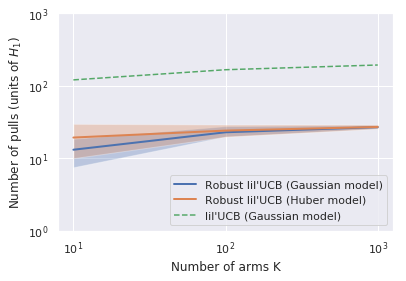

In [22]:
## sns.set()

# grid for both axis
plt.rcParams["axes.grid.axis"] ='both'

H_1 = [4*K for K in nb_of_arms]

# robust lilUCB, Gaussian model
plt.loglog(nb_of_arms, np.mean(nb_of_pulls_robustlilUCB, axis=1)/H_1, linewidth=2)
plt.fill_between(nb_of_arms, np.percentile(nb_of_pulls_robustlilUCB, q=97.5, axis=1)/H_1, 
                 np.percentile(nb_of_pulls_robustlilUCB, axis=1, q=2.5)/H_1, alpha=.3)

# robust lilUCB, Huber model
plt.semilogx(nb_of_arms, np.mean(nb_of_pulls_robustlilUCB_huber, axis=1)/H_1, linewidth=2)
plt.fill_between(nb_of_arms, np.percentile(nb_of_pulls_robustlilUCB_huber, q=97.5, axis=1)/H_1, 
                 np.percentile(nb_of_pulls_robustlilUCB_huber, q=2.5, axis=1)/H_1, alpha=.3)

plt.semilogx(nb_of_arms, np.mean(nb_of_pulls_lilUCB, axis=1)/H_1, linewidth=1.5, linestyle='--')

plt.xlabel('Number of arms K')
plt.ylim(1, 1000)
plt.ylabel('Number of pulls (units of $H_1$)')
plt.legend(["Robust lil'UCB (Gaussian model)", "Robust lil'UCB (Huber model)", "lil'UCB (Gaussian model)"],
           loc='lower right')
savefig('experiments_results/number_of_pulls_alpha_3.pdf', bbox_inches='tight', dpi=500)

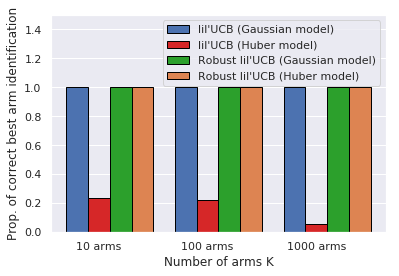

In [23]:
# only display horizontal grid
plt.rcParams["axes.grid.axis"] ='y'

ind = np.array([10, 20, 30])
width = 2

prop_1 = np.sum(BAI_lilUCB==0, axis=1)/n_repeat
prop_2 = np.sum(BAI_lilUCB_huber==0, axis=1)/n_repeat
prop_3 = np.sum(BAI_robustlilUCB==0, axis=1)/n_repeat
prop_4 = np.sum(BAI_robustlilUCB_huber==0, axis=1)/n_repeat

## the bars
rects1 = plt.bar(ind, prop_1, width, edgecolor="black")
rects2 = plt.bar(ind+width, prop_2, width, color='#d62728', edgecolor="black")
rects3 = plt.bar(ind+2*width, prop_3, width, color='#2ca02c', edgecolor="black")
rects4 = plt.bar(ind+3*width, prop_4, width, edgecolor="black")
plt.xlabel('Number of arms K')
plt.ylabel('Prop. of correct best arm identification')
plt.legend(["lil'UCB (Gaussian model)", "lil'UCB (Huber model)", 
            "Robust lil'UCB (Gaussian model)","Robust lil'UCB (Huber model)"])
plt.ylim(0, 1.5)
plt.xticks(ind+width, ["{} arms".format(x) for x in nb_of_arms])
savefig('experiments_results/prop_correct_bai_alpha_3.pdf', bbox_inches='tight', dpi=500)

# Compare LIL bound to union bound 

$Y_1, \dots, Y_n$ iid sub-gaussian random variables with mean $\mu$ and sub-Gaussian variance $\sigma^2$.

**Union bound**

The folowing tail bound inequality stems from the sub-Gaussian assumption :

\begin{align}
\mathbb{P}\left( \lvert \bar{Y}_n - \mu \rvert > \sigma \sqrt{2} \sqrt{\frac{\ln 1/\delta}{n}} \right) \leq \delta
\end{align}

A simple union bound gives

\begin{align}
\mathbb{P}\left(\forall n \geq 1, \lvert \bar{Y}_n - \mu \rvert > \sigma \sqrt{2} \sqrt{\frac{\ln n^2/\delta}{n}} \right) \leq \frac{\pi^2}{6}\delta
\end{align}


**LIL bound**

The loss corresponding to the mean is given by $\phi(x, y) = (x-y)^2$. The loss verifies the assumptions of Theorem 2 with $r=+\infty, n_0 = 1, \alpha=2$ therefore, for any $\varepsilon > 0$ we have,

\begin{align}
\mathbb{P}\left( \forall n \geq 1, \lvert \bar{Y}_n - \mu \rvert \geq 2 \sigma \sqrt{\frac{2(1+\varepsilon)\ln \ln n + \ln 1/\delta}{n}} \right) \leq \frac{4(1+1/\varepsilon)}{(\ln(1+\varepsilon))^{1+\varepsilon}}
\end{align}



In [3]:
def UB(n, ν, σ=1.):
    δ = 6*ν/np.pi**2
    print("Union bound confidence : {}".format(δ))
    return np.sqrt(2)*σ*np.sqrt((2*np.log(n) - np.log(δ))/n)

UB(n=1e3, ν=0.1, σ=1.)

def LIL(n, ν, ɛ=1., σ=1.):
    δ = np.log(1+ɛ)**(1+ɛ)/(4*(1+1/ɛ))*ν
    print("LIL confidence : {}".format(δ))
    return 2*σ*np.sqrt((2*((1+ɛ)*np.log(np.log(n)) + np.log(1/δ)))/n)

LIL(n=1e3, ν=0.1, ɛ=1., σ=1.)

def LIL_empirical(n, ν, ɛ=1., σ=1.):
    δ = np.log(1+ɛ)**(1+ɛ)/(4*(1+1/ɛ))*ν
    print("LIL confidence : {}".format(δ))
    return σ*np.sqrt((2*((1+ɛ)*np.log(np.log(n)) + np.log(1/δ)))/n)

LIL_empirical(n=1e3, ν=0.1, ɛ=1., σ=1.)

def LIL_original(n, ν, ɛ=.01, σ=1.):
    δ = np.log(1+ɛ)*(ν*ɛ/(4 + 2*ɛ))**(1/(1+ɛ))
    print("LIL original confidence : {}".format(δ))
    return (1+np.sqrt(ɛ))*σ*np.sqrt(2*np.log(np.log((1+ɛ)*n)/δ)/n)

LIL_original(n=1e3, ν=0.1, ɛ=.01, σ=1.)

Union bound confidence : 0.06079271018540268
LIL confidence : 0.006005662673977518
LIL confidence : 0.006005662673977518
LIL original confidence : 2.6871807199787257e-06


0.18900229403828389

LIL confidence : 1.7123815553433657e-05
Union bound confidence : 0.006079271018540266
LIL confidence : 8.561907776716828e-05
Union bound confidence : 0.03039635509270134
LIL confidence : 0.00017123815553433657
Union bound confidence : 0.06079271018540268


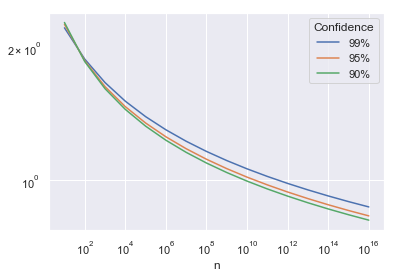

In [4]:
n = np.logspace(1, 16, 16, dtype=int)

ɛ = 0.1

ν = 0.01
plt.loglog(n, LIL(n, ν, ɛ)/UB(n, ν))

ν = 0.05
plt.loglog(n, LIL(n, ν, ɛ)/UB(n, ν))

ν = 0.1
plt.loglog(n, LIL(n, ν, ɛ)/UB(n, ν))

plt.legend(title="Confidence", labels=['99%', '95%', '90%'])

plt.xlabel('n')
#plt.title('LIL bound over union bound upper bound ratio (log scale)')

LIL original confidence : 2.749146381419433e-07
Union bound confidence : 0.006079271018540266
LIL original confidence : 1.3528429233171744e-06
Union bound confidence : 0.03039635509270134
LIL original confidence : 2.6871807199787257e-06
Union bound confidence : 0.06079271018540268


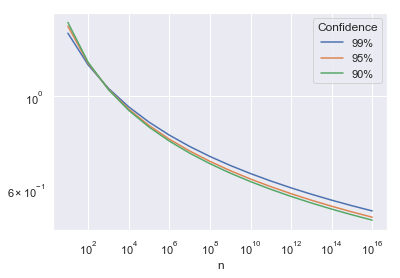

In [5]:
n = np.logspace(1, 16, 16, dtype=int)

ɛ = 0.01

ν = 0.01
plt.loglog(n, LIL_original(n, ν, ɛ)/UB(n, ν))

ν = 0.05
plt.loglog(n, LIL_original(n, ν, ɛ)/UB(n, ν))

ν = 0.1
plt.loglog(n, LIL_original(n, ν, ɛ)/UB(n, ν))

plt.legend(title="Confidence", labels=['99%', '95%', '90%'])

plt.xlabel('n')
#plt.title('LIL bound over union bound upper bound ratio (log scale)')

LIL confidence : 2.3519849129445292e-07
Union bound confidence : 0.006079271018540266
LIL confidence : 1.1759924564722647e-06
Union bound confidence : 0.03039635509270134
LIL confidence : 2.3519849129445294e-06
Union bound confidence : 0.06079271018540268


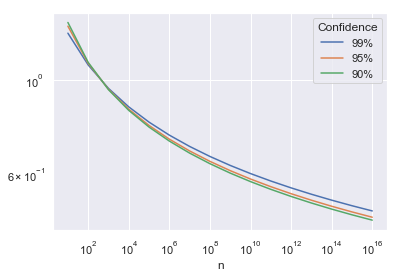

In [6]:
# empirical 

n = np.logspace(1, 16, 16, dtype=int)

ɛ = 0.01

ν = 0.01
plt.loglog(n, LIL_empirical(n, ν, ɛ)/UB(n, ν))

ν = 0.05
plt.loglog(n, LIL_empirical(n, ν, ɛ)/UB(n, ν))

ν = 0.1
plt.loglog(n, LIL_empirical(n, ν, ɛ)/UB(n, ν))

plt.legend(title="Confidence", labels=['99%', '95%', '90%'])

plt.xlabel('n')
#plt.title('LIL bound over union bound upper bound ratio (log scale)')